In [1]:
from sklearn import datasets
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score

from amltlearn.cluster.MembraneClustering import *

import time
import matplotlib.pyplot as plt
import random
%matplotlib inline 

# Set seed for reproducibility
seed = 20
random.seed(seed)
np.random.seed(seed)

In [2]:
# Circles dataset 

def get_circles(circles_data):
    """ Input is a list of lists where each element is a circle definition:
        [minimum_radius, maximum_radius, instances]
    """
    
    def get_circle(radius_s, radius_e, num):
        data = np.zeros((num, 2))
        for i in range(len(data)):
            radius = random.uniform(radius_s, radius_e)
            if np.random.randint(10) % 2 == 0:
                # Sample x and compute y
                x = random.uniform(-radius, radius)
                y = np.sqrt(np.square(radius) - np.square(x)) * np.sign(random.uniform(-1, 1))
            else:
                # Sample y and compute x
                y = random.uniform(-radius, radius)
                x = np.sqrt(np.square(radius) - np.square(y)) * np.sign(random.uniform(-1, 1))

            data[i, ...] = np.array([x, y])
        return data
    
    x_data = [get_circle(c[0], c[1], c[2]) for c in circles_data]
    y_data = [np.ones((c[2], 1)) * i + 1 for i, c in enumerate(circles_data)]
    return np.vstack(x_data), np.vstack(y_data)

In [3]:
# Fine tuning functions


# KMEANS FUNCTIONS

def kmeans_test(X, max_clusters=10, n_jobs=2):
    """ Grid search on Kmeans for number of clusters """
    best = None
    for k in range(2, max_clusters+1):
        kmeans = KMeans(n_clusters=k, n_jobs=n_jobs).fit(X)
        score = silhouette_score(X, kmeans.labels_)

        print('Testing k: %f [%f]' % (k, score))
        if best is None or score > best['score'] :
            best = {'k': k, 'score': score}
                    
    print('Best configuration is {}'.format(best))
    return best


def predict_kmeans(X, n_jobs = 2):
    """ Predicts Kmeans for the input data. Does a grid search over number of clusters """
    best = kmeans_test(X, n_jobs=n_jobs)
    return KMeans(n_clusters=best['k'], n_jobs=n_jobs).fit(X).labels_


# AGGLOMERATIVE CLUSTERING FUNCTIONS

def ac_test(X, max_clusters=10):
    """ Grid search on Agglomerative Clustering """
    best = None
    for k in range(2, max_clusters+1):
        ac = AgglomerativeClustering(n_clusters=k, linkage='ward').fit(X)
        score = silhouette_score(X, ac.labels_)

        print('Testing k: %f [%f]' % (k, score))
        if best is None or score > best['score']:
            best = {'k': k, 'score': score}
                    
    print('Best configuration is {}'.format(best))
    return best


def predict_ac(X):
    """ Predicts Agglomerative Clustering for the input data. Does a grid search over number of clusters """
    best = ac_test(X)
    return AgglomerativeClustering(n_clusters=best['k'], linkage='ward').fit(X).labels_

In [78]:
# Functions to test an input dataset

def centers_to_obj(data, centers, k_max):
    """ Converts cluster centers into a Membrane Clustering object"""
    center_shape = data.shape[1]
    pos = np.zeros(k_max * center_shape + k_max)
    for i in range(centers.shape[0]):
        pos[i] = 1.0
        init = k_max + i * center_shape
        end = k_max + (i+1) * center_shape
        pos[init:end] = centers[i, ...]
    return ObjectStr(data, k_max, Metric.CLUSTER_SEPARATION, 'euclidean', position=pos, velocity=0, cs=0)


def test_data(x_data, k_max=5, its=75, m=5, q=4):
    """ Gets the labels for the clustering of the input dataset for: KMeans, Agglomerative clustering 
    and Membrane Clustering. The two first are tuned under grid search on the number of clusters """
    
    # KMeans
    kmeans_labels = predict_kmeans(x_data)
    # Agglomerative Clustering
    ac_labels = predict_ac(x_data)
    
    # Membrane clustering
    lower_bound, upper_bound = data_bounds(x_data)
    env = Environment(x_data,
            k_max=k_max,
            max_t=its,
            q=q,
            min_w=0.2,
            max_w=0.5,
            m=m,
            c1=0.5,
            c2=0.5,
            c3=0.5,
            lower_b=lower_bound,
            upper_b=upper_bound)
    env.fit()
    mem_labels = env.predict(x_data)
    
    return kmeans_labels, ac_labels, mem_labels, env

def plot_data(X, km, ac, mem, y_data, path=None, index_x=0, index_y=1):
    """ Plots predictions and groundtruth (y_data) in a grid """
    f, axarr = plt.subplots(2, 2, figsize=(10, 6))

    axarr[0, 0].scatter(X[:, index_x], X[:, index_y], c=km)
    axarr[0, 0].set_title('KMeans')

    axarr[0, 1].scatter(X[:, index_x], X[:, index_y], c=ac)
    axarr[0, 1].set_title('Agglomerative')

    axarr[1, 0].scatter(X[:, index_x], X[:, index_y], c=mem)
    axarr[1, 0].set_title('Membrane clustering')

    axarr[1, 1].scatter(X[:, index_x], X[:, index_y], c=y_data)
    axarr[1, 1].set_title('Groundtruth')

    if path is not None:
        plt.savefig(path)

def show_scores(km, ac, mem, y_data):
    """ Shows Adjusted rand scores for the predictions """
    print('Adjustes Rand Score for KMeans %f' % adjusted_rand_score(km, y_data))
    print('Adjustes Rand Score for Mem %f' % adjusted_rand_score(mem, y_data))
    print('Adjustes Rand Score for Agglomerative Clustering %f' % adjusted_rand_score(ac, y_data))

Testing k: 2.000000 [0.314694]
Testing k: 3.000000 [0.344199]
Testing k: 4.000000 [0.388289]
Testing k: 5.000000 [0.495657]
Testing k: 6.000000 [0.506099]
Testing k: 7.000000 [0.511311]
Testing k: 8.000000 [0.508634]
Testing k: 9.000000 [0.419127]
Testing k: 10.000000 [0.412017]
Best configuration is {'k': 7, 'score': 0.51131083124067456}
Testing k: 2.000000 [0.320093]
Testing k: 3.000000 [0.356555]
Testing k: 4.000000 [0.419042]
Testing k: 5.000000 [0.466537]
Testing k: 6.000000 [0.487421]
Testing k: 7.000000 [0.496490]
Testing k: 8.000000 [0.495460]
Testing k: 9.000000 [0.406644]
Testing k: 10.000000 [0.398219]
Best configuration is {'k': 7, 'score': 0.49648996768738524}
Creating object 0
Creating object 0
Creating object 0
Creating object 0
Creating cell 0
Creating cell 1
Creating cell 2
Creating cell 3
Creating object 1
Creating object 1
Creating object 1
Creating object 1
Creating object 2
Creating object 2
Creating object 2
Creating object 2
Creating object 3
Creating object 3
Cr

100%|██████████| 75/75 [01:08<00:00,  1.10it/s]      | 1/75 [00:00<00:15,  4.85it/s]


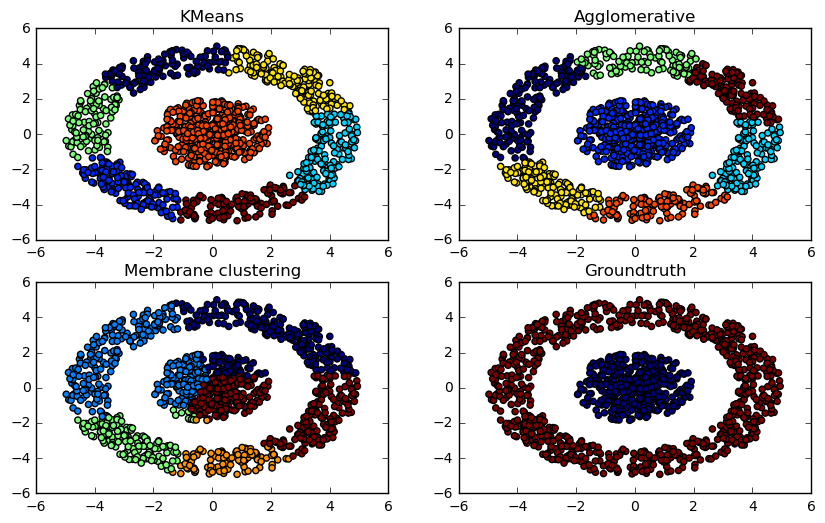

In [101]:
# Circles dataset
x_circles, y_circles = get_circles([[0, 2, 500], [3.5, 5, 800]])
km, ac, mem, _ = test_data(x_circles)
plot_data(x_circles, km, ac, mem, y_circles)

Testing k: 2.000000 [0.562324]
Testing k: 3.000000 [0.674709]
Testing k: 4.000000 [0.778352]
Testing k: 5.000000 [0.609675]
Testing k: 6.000000 [0.457682]
Testing k: 7.000000 [0.277393]
Testing k: 8.000000 [0.114664]
Testing k: 9.000000 [0.115034]
Testing k: 10.000000 [0.107040]
Best configuration is {'k': 4, 'score': 0.77835192556829447}
Testing k: 2.000000 [0.562324]
Testing k: 3.000000 [0.674709]
Testing k: 4.000000 [0.778352]
Testing k: 5.000000 [0.617157]
Testing k: 6.000000 [0.441112]
Testing k: 7.000000 [0.274716]
Testing k: 8.000000 [0.277088]
Testing k: 9.000000 [0.095485]
Testing k: 10.000000 [0.093038]
Best configuration is {'k': 4, 'score': 0.77835192556829447}
Creating object 0
Creating object 0
Creating object 0
Creating object 0
Creating object 1
Creating cell 0
Creating cell 1
Creating cell 2
Creating cell 3
Creating object 1
Creating object 1
Creating object 1
Creating object 2
Creating object 2
Creating object 2
Creating object 3
Creating object 3
Creating object 4
Cr

100%|██████████| 75/75 [00:31<00:00,  2.21it/s]      | 1/75 [00:00<00:14,  5.17it/s]


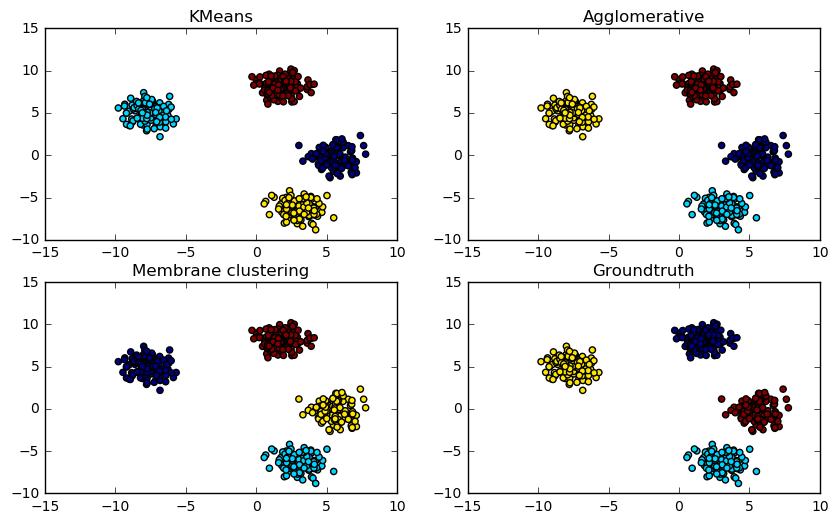

In [99]:
# Make blobs
x_blobs, y_blobs = datasets.make_blobs(n_samples=450, n_features=8, centers=4, random_state=seed)
km_b, ac_b, mem_b, _ = test_data(x_blobs)
plot_data(x_blobs, km_b, ac_b, mem_b, y_blobs)

Testing k: 2.000000 [0.497602]
Testing k: 3.000000 [0.566577]
Testing k: 4.000000 [0.626946]
Testing k: 5.000000 [0.508744]
Testing k: 6.000000 [0.378229]
Testing k: 7.000000 [0.240456]
Testing k: 8.000000 [0.110467]
Testing k: 9.000000 [0.116067]
Testing k: 10.000000 [0.107891]
Best configuration is {'k': 4, 'score': 0.62694638175172646}
Testing k: 2.000000 [0.497602]
Testing k: 3.000000 [0.566577]
Testing k: 4.000000 [0.626946]
Testing k: 5.000000 [0.504907]
Testing k: 6.000000 [0.368787]
Testing k: 7.000000 [0.240753]
Testing k: 8.000000 [0.241393]
Testing k: 9.000000 [0.095485]
Testing k: 10.000000 [0.093038]
Best configuration is {'k': 4, 'score': 0.62694638175172646}
Creating object 0
Creating object 0
Creating object 0
Creating object 0
Creating cell 0
Creating cell 1
Creating cell 2
Creating cell 3
Creating object 1
Creating object 1
Creating object 1
Creating object 1
Creating object 2
Creating object 2
Creating object 2
Creating object 2
Creating object 3
Creating object 3
Cr

100%|██████████| 150/150 [01:16<00:00,  1.64it/s]     | 1/150 [00:00<00:31,  4.75it/s]


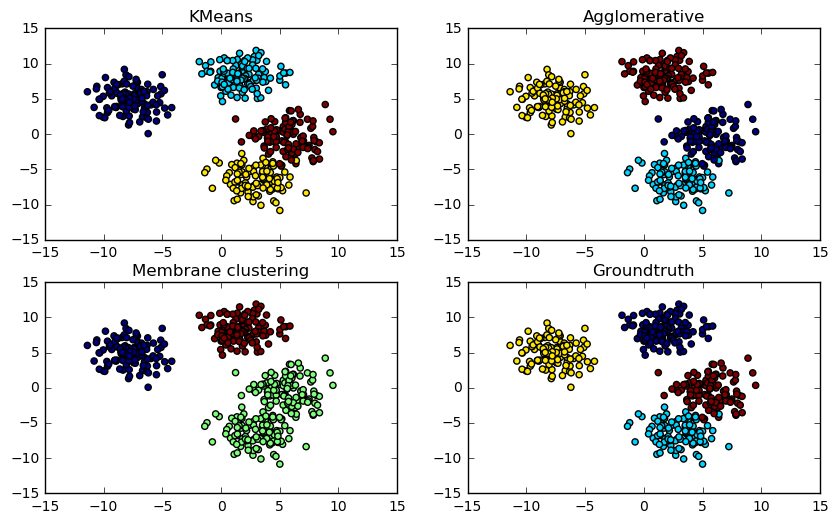

In [104]:
# Make blobs
x_blobs2, y_blobs2 = datasets.make_blobs(n_samples=450, n_features=8, centers=4, random_state=seed, 
                                      cluster_std=1.75)
km_b2, ac_b2, mem_b2, _ = test_data(x_blobs2, its=150)
plot_data(x_blobs2, km_b2, ac_b2, mem_b2, y_blobs2)

Testing k: 2.000000 [0.488837]
Testing k: 3.000000 [0.418849]
Testing k: 4.000000 [0.458348]
Testing k: 5.000000 [0.482437]
Testing k: 6.000000 [0.511873]
Testing k: 7.000000 [0.516459]
Testing k: 8.000000 [0.523342]
Testing k: 9.000000 [0.519481]
Testing k: 10.000000 [0.510302]
Best configuration is {'k': 8, 'score': 0.52334210115791169}
Testing k: 2.000000 [0.440617]
Testing k: 3.000000 [0.404300]
Testing k: 4.000000 [0.406602]
Testing k: 5.000000 [0.474607]
Testing k: 6.000000 [0.499570]
Testing k: 7.000000 [0.505077]
Testing k: 8.000000 [0.504867]
Testing k: 9.000000 [0.493907]
Testing k: 10.000000 [0.491612]
Best configuration is {'k': 7, 'score': 0.50507707921397371}
Creating object 0
Creating object 0
Creating object 0
Creating object 0
Creating object 1
Creating object 1
Creating object 2
Creating object 2
Creating object 3
Creating cell 0
Creating cell 1
Creating cell 2
Creating cell 3
Creating object 1
Creating object 1
Creating object 3
Creating object 4
Creating object 4
Cr

100%|██████████| 75/75 [00:23<00:00,  2.93it/s]      | 1/75 [00:00<00:17,  4.24it/s]


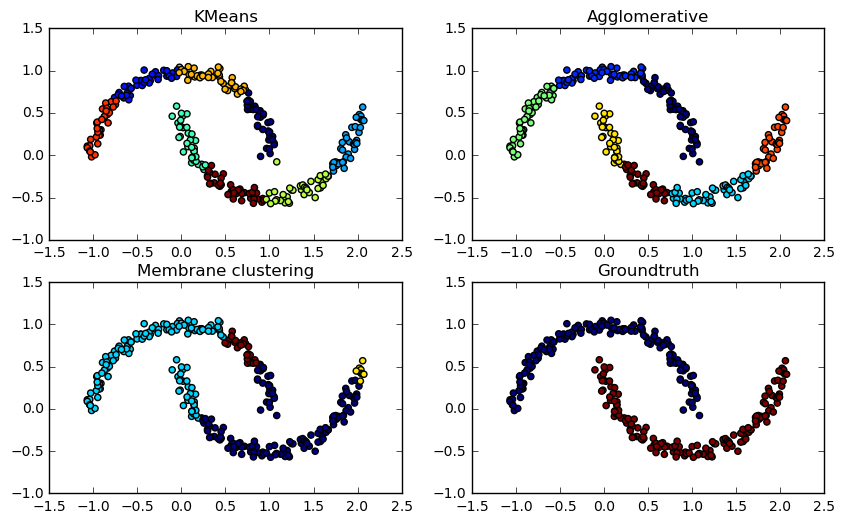

In [106]:
# Make moons
x_moons, y_moons = datasets.make_moons(n_samples=300, noise=0.05)
km_m, ac_m, mem_m, _ = test_data(x_moons)
plot_data(x_moons, km_m, ac_m, mem_m, y_moons)

Testing k: 2.000000 [0.680814]
Testing k: 3.000000 [0.552592]
Testing k: 4.000000 [0.497826]
Testing k: 5.000000 [0.488518]
Testing k: 6.000000 [0.367653]
Testing k: 7.000000 [0.349174]
Testing k: 8.000000 [0.353609]
Testing k: 9.000000 [0.335010]
Testing k: 10.000000 [0.311105]
Best configuration is {'k': 2, 'score': 0.68081362027135062}
Testing k: 2.000000 [0.686393]
Testing k: 3.000000 [0.554097]
Testing k: 4.000000 [0.488740]
Testing k: 5.000000 [0.484155]
Testing k: 6.000000 [0.361885]
Testing k: 7.000000 [0.344854]
Testing k: 8.000000 [0.346241]
Testing k: 9.000000 [0.333139]
Testing k: 10.000000 [0.329160]
Best configuration is {'k': 2, 'score': 0.68639305432048481}
Creating object 0
Creating object 0
Creating object 0
Creating object 0
Creating object 1
Creating object 1
Creating object 2
Creating object 1
Creating object 2
Creating object 1
Creating object 3
Creating object 2
Creating object 2
Creating object 3
Creating object 3
Creating object 4
Creating object 3
Creating obj

100%|██████████| 75/75 [00:24<00:00,  2.38it/s]      | 1/75 [00:00<00:15,  4.75it/s]


Adjustes Rand Score for KMeans 0.539922
Adjustes Rand Score for Mem 0.568116
Adjustes Rand Score for Agglomerative Clustering 0.568116


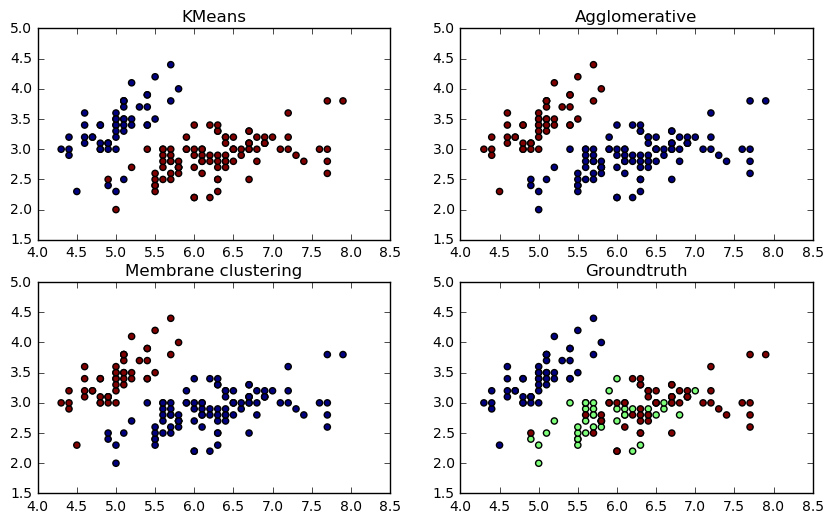

In [91]:
# UCI dataset: IRIS data
iris = datasets.load_iris()
x_iris, y_iris = iris.data, iris.target
km_ir, ac_ir, mem_ir, mem_model_iris = test_data(x_iris)
plot_data(x_iris, km_ir, ac_ir, mem_ir, y_iris)
show_scores(km_ir, ac_ir, mem_ir, y_iris)

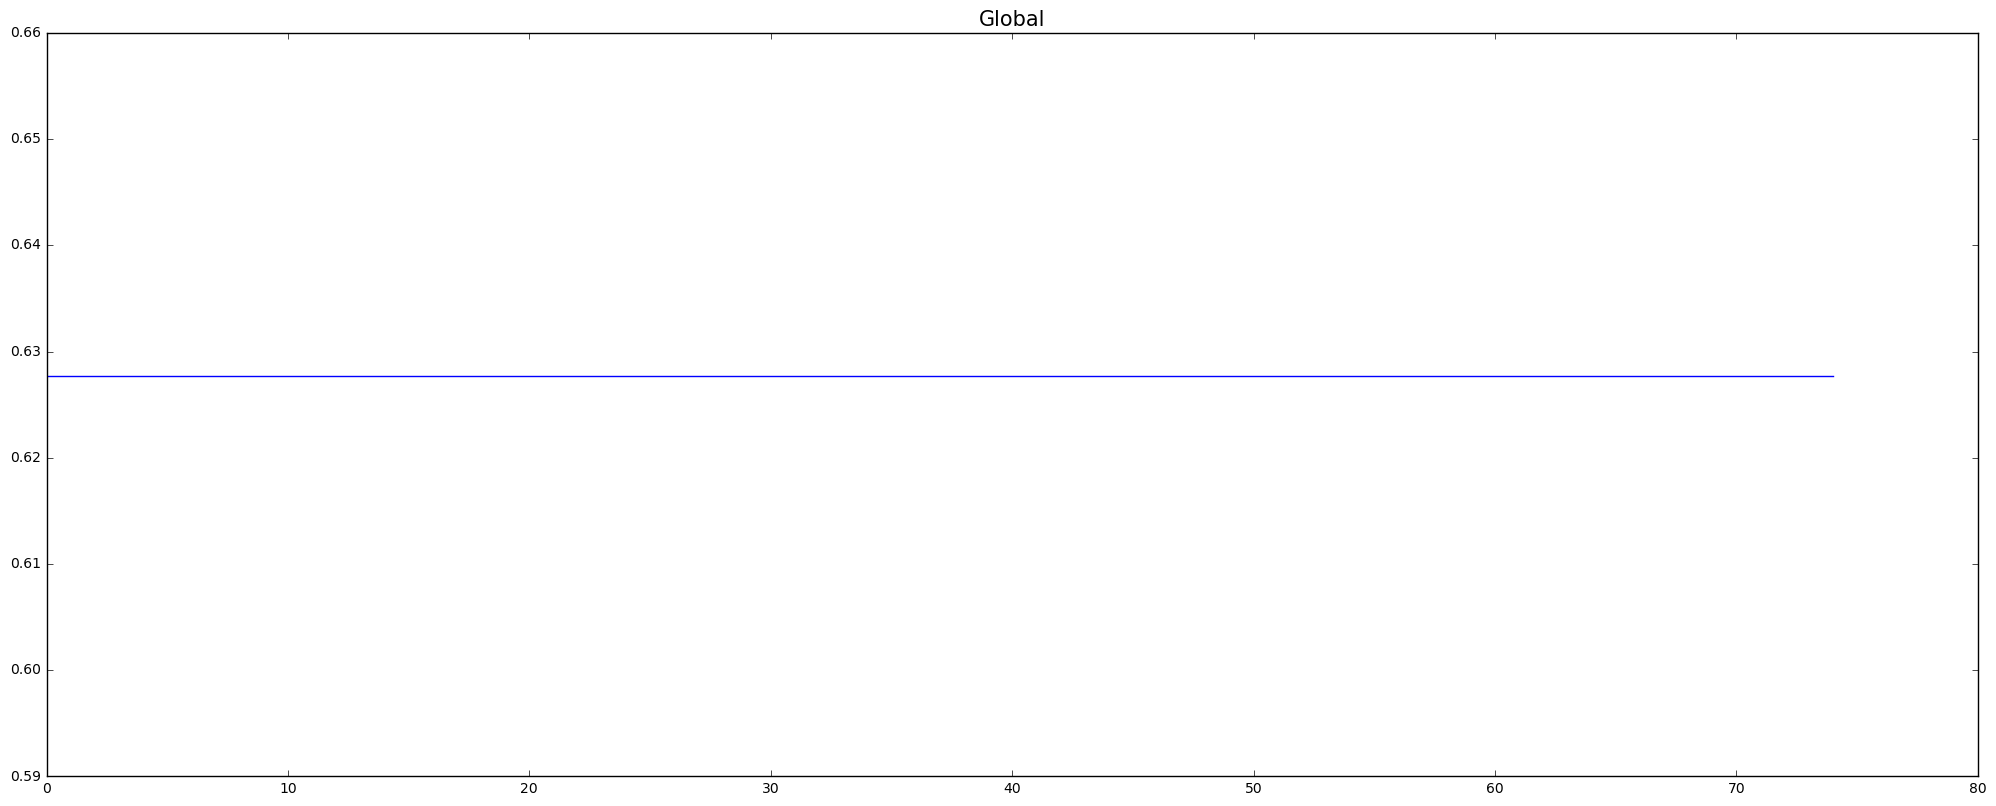

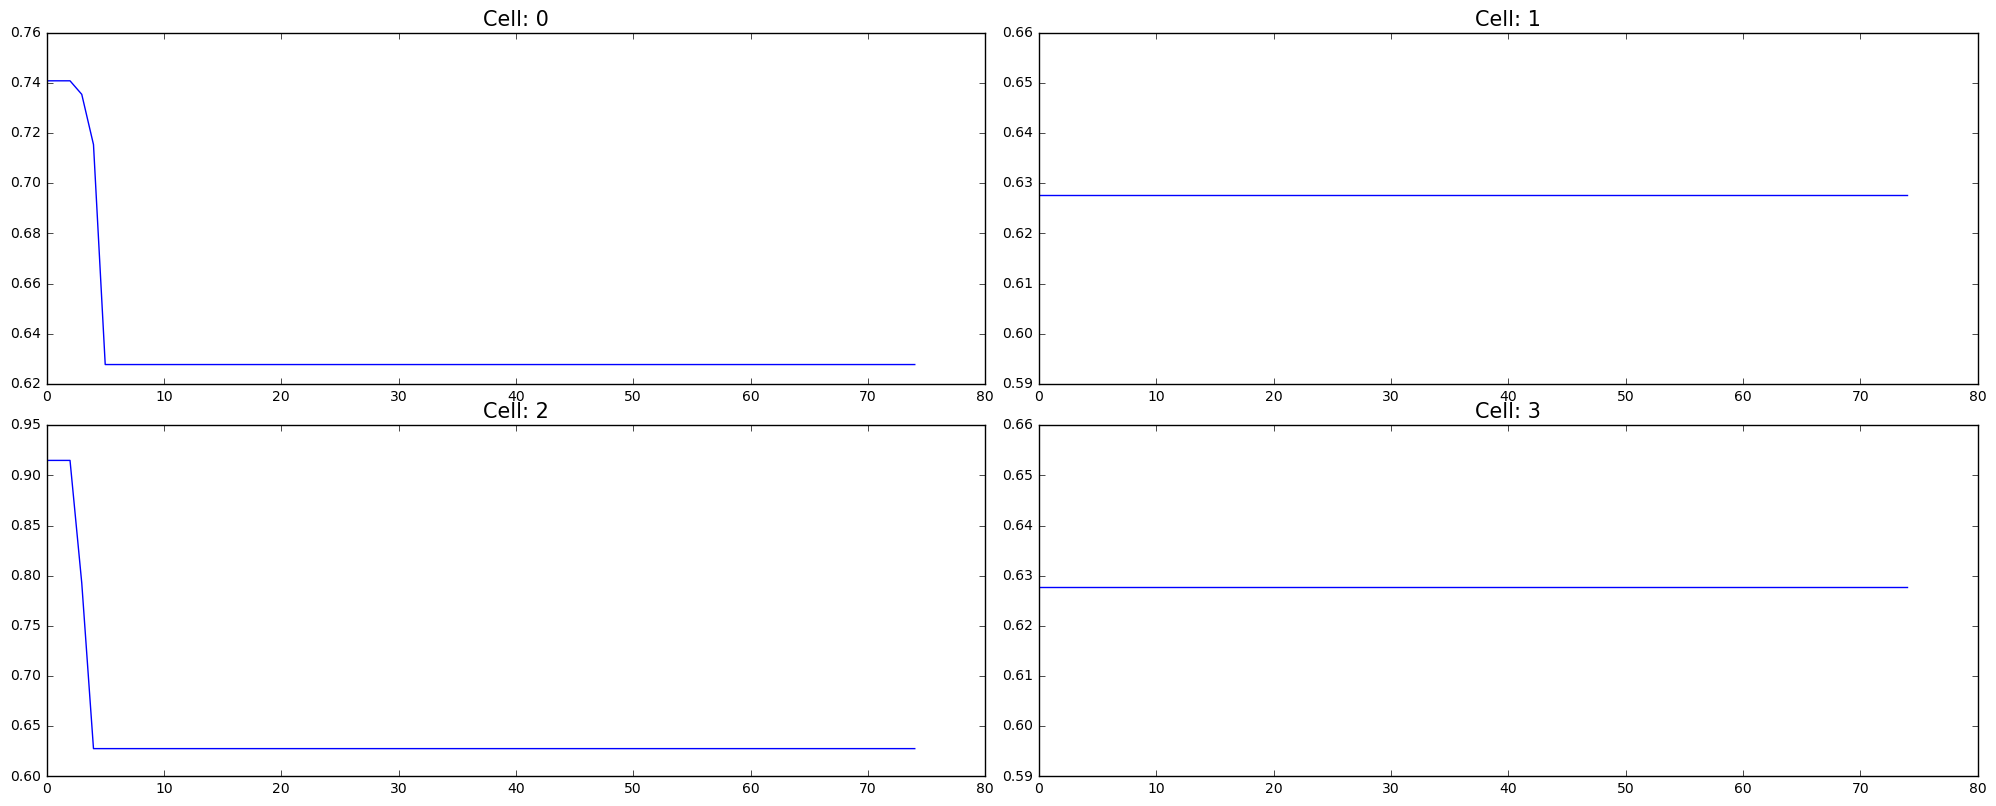

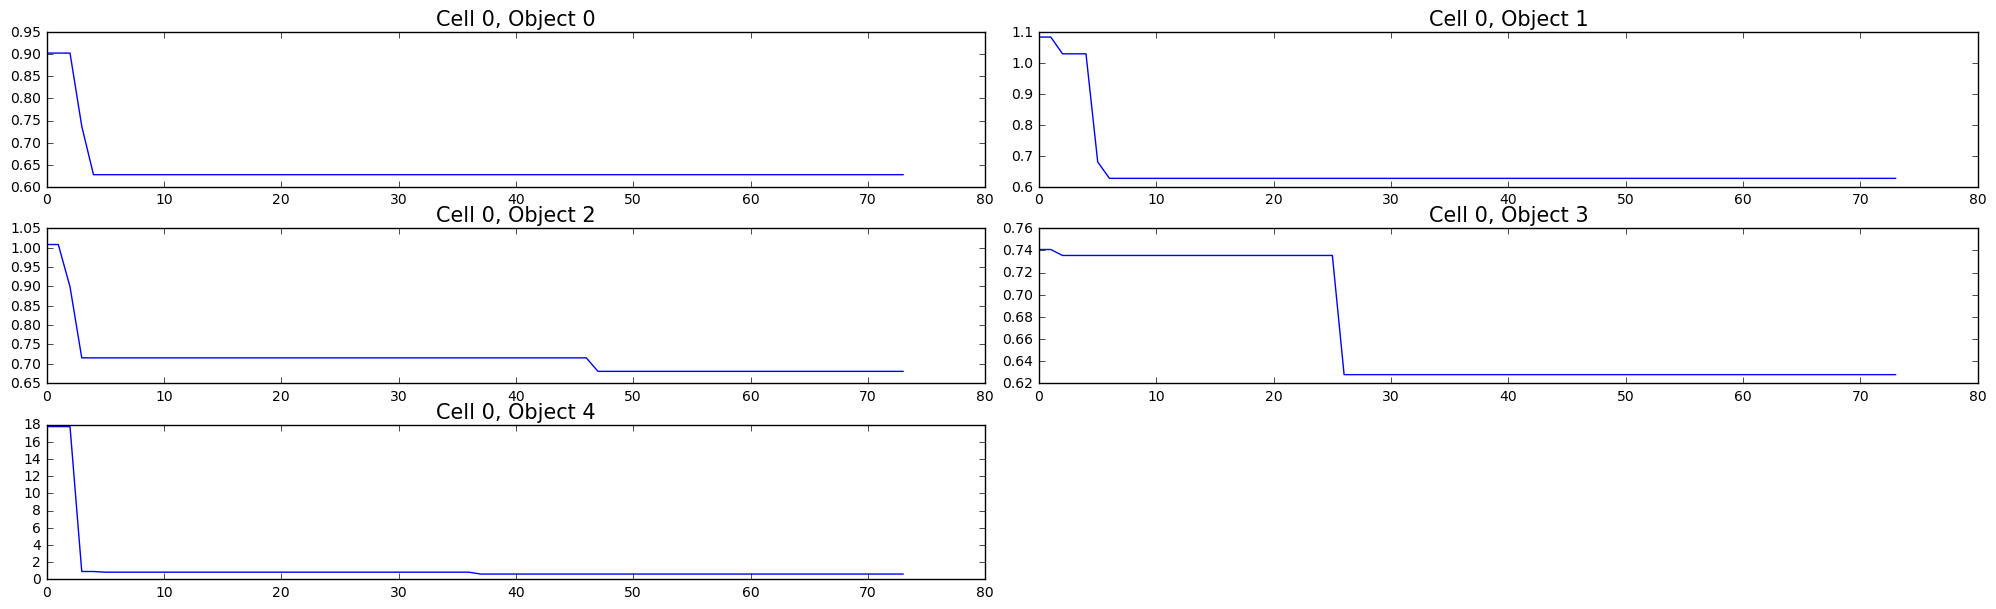

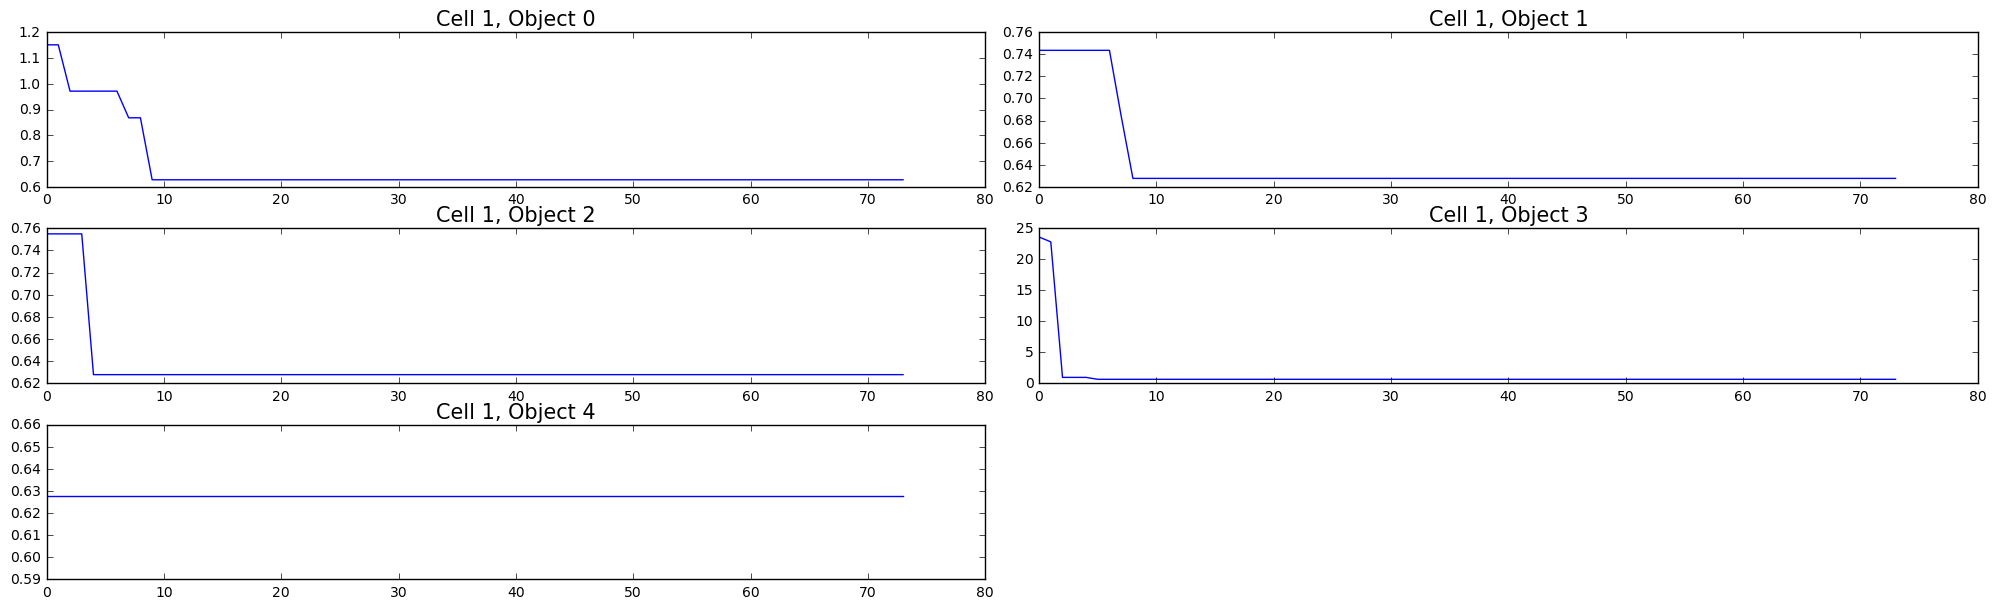

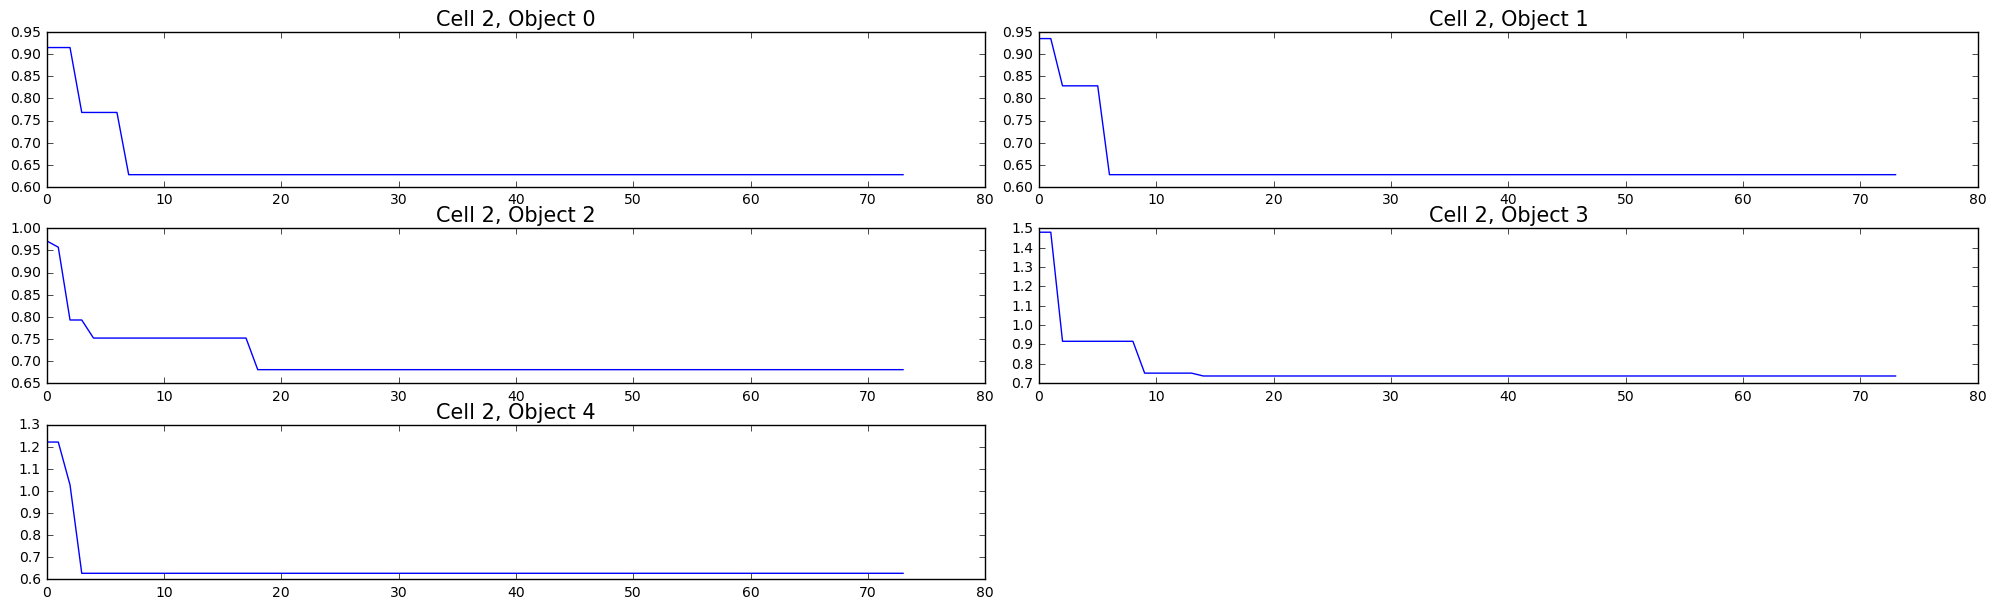

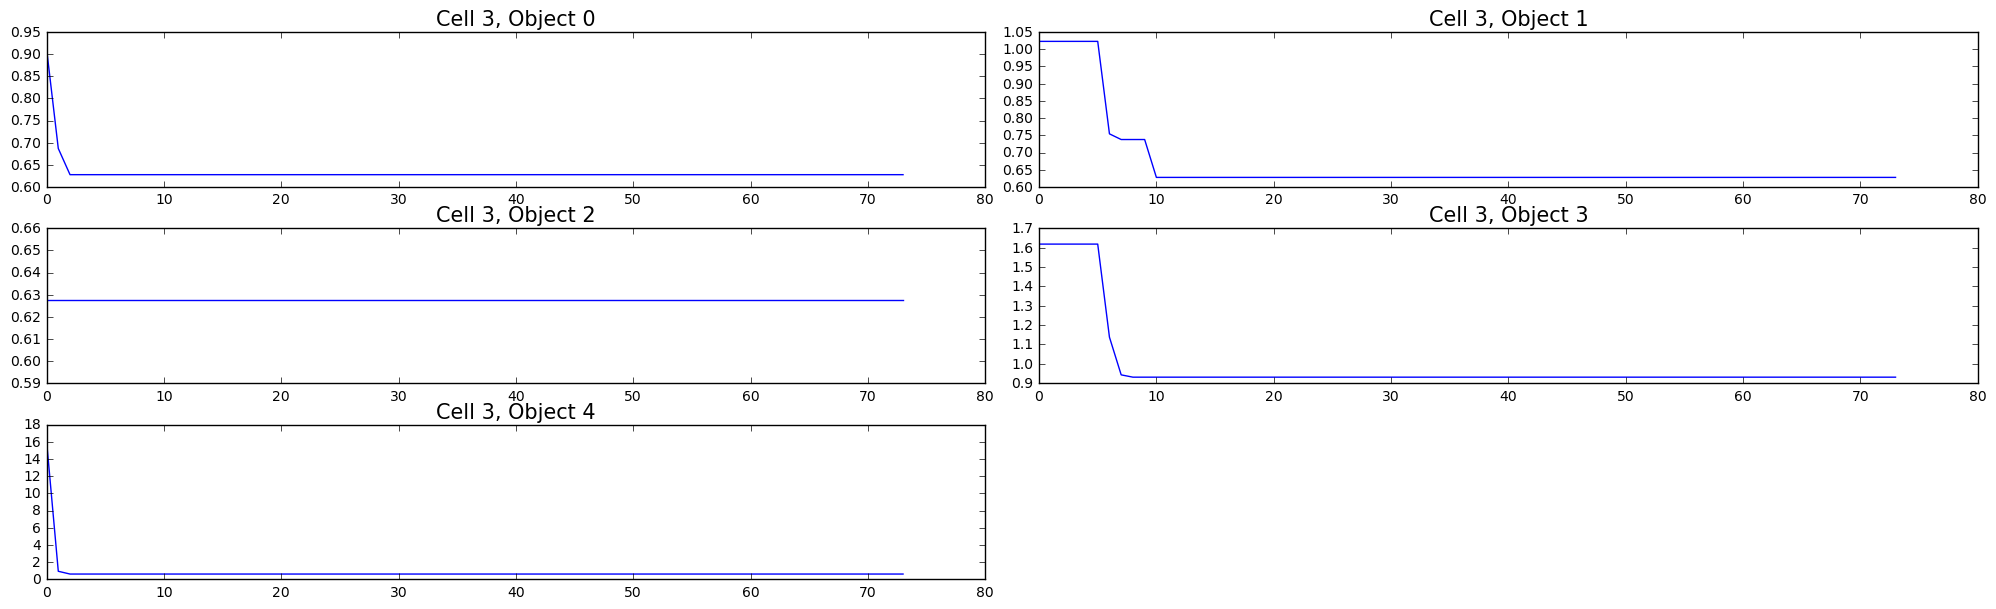

In [50]:
# Check algorithm convergence - We see model does not evolve since initialization is good enough
mem_model_iris.plot()

Testing k: 2.000000 [0.298722]
Testing k: 3.000000 [0.299367]
Testing k: 4.000000 [0.259750]
Testing k: 5.000000 [0.221418]
Testing k: 6.000000 [0.184335]
Testing k: 7.000000 [0.201608]
Testing k: 8.000000 [0.135018]
Testing k: 9.000000 [0.151370]
Testing k: 10.000000 [0.143328]
Best configuration is {'k': 3, 'score': 0.29936673663542168}
Testing k: 2.000000 [0.296668]
Testing k: 3.000000 [0.294829]
Testing k: 4.000000 [0.248703]
Testing k: 5.000000 [0.204154]
Testing k: 6.000000 [0.207787]
Testing k: 7.000000 [0.204891]
Testing k: 8.000000 [0.211014]
Testing k: 9.000000 [0.212090]
Testing k: 10.000000 [0.154651]
Best configuration is {'k': 2, 'score': 0.29666793736848984}
Creating object 0
Creating object 0
Creating object 0
Creating object 0
Creating object 1
Creating object 1
Creating cell 0
Creating cell 1
Creating cell 2
Creating cell 3
Creating object 1
Creating object 1
Creating object 2
Creating object 2
Creating object 3
Creating object 2
Creating object 3
Creating object 3
Cr

100%|██████████| 75/75 [00:27<00:00,  2.30it/s]      | 1/75 [00:00<00:17,  4.31it/s]


Adjustes Rand Score for KMeans 0.868543
Adjustes Rand Score for Mem 0.457689
Adjustes Rand Score for Agglomerative Clustering 0.484739


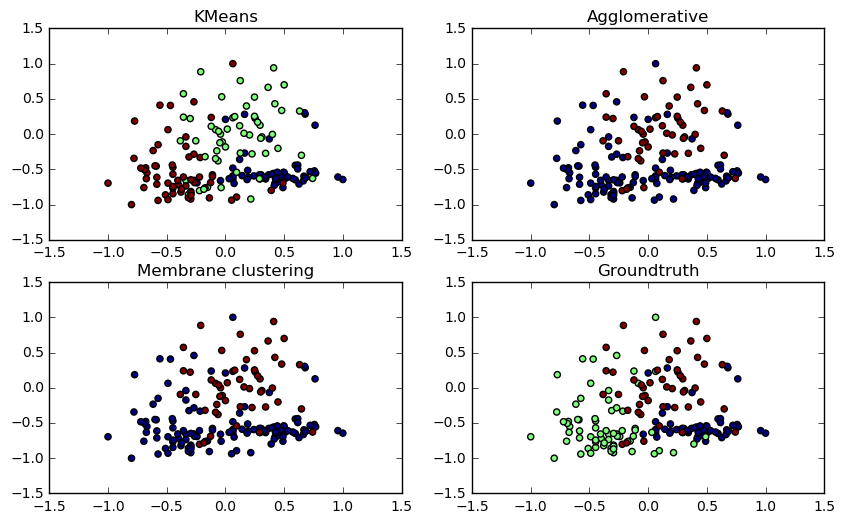

In [81]:
# UCI dataset: Wine data
data = datasets.fetch_mldata('wine')
x_wine, y_wine = data['data'], data['target']
km_w, ac_w, mem_w, mem_model_wine = test_data(x_wine)
plot_data(x_wine, km_w, ac_w, mem_w, y_wine)
show_scores(km_w, ac_w, mem_w, y_wine)

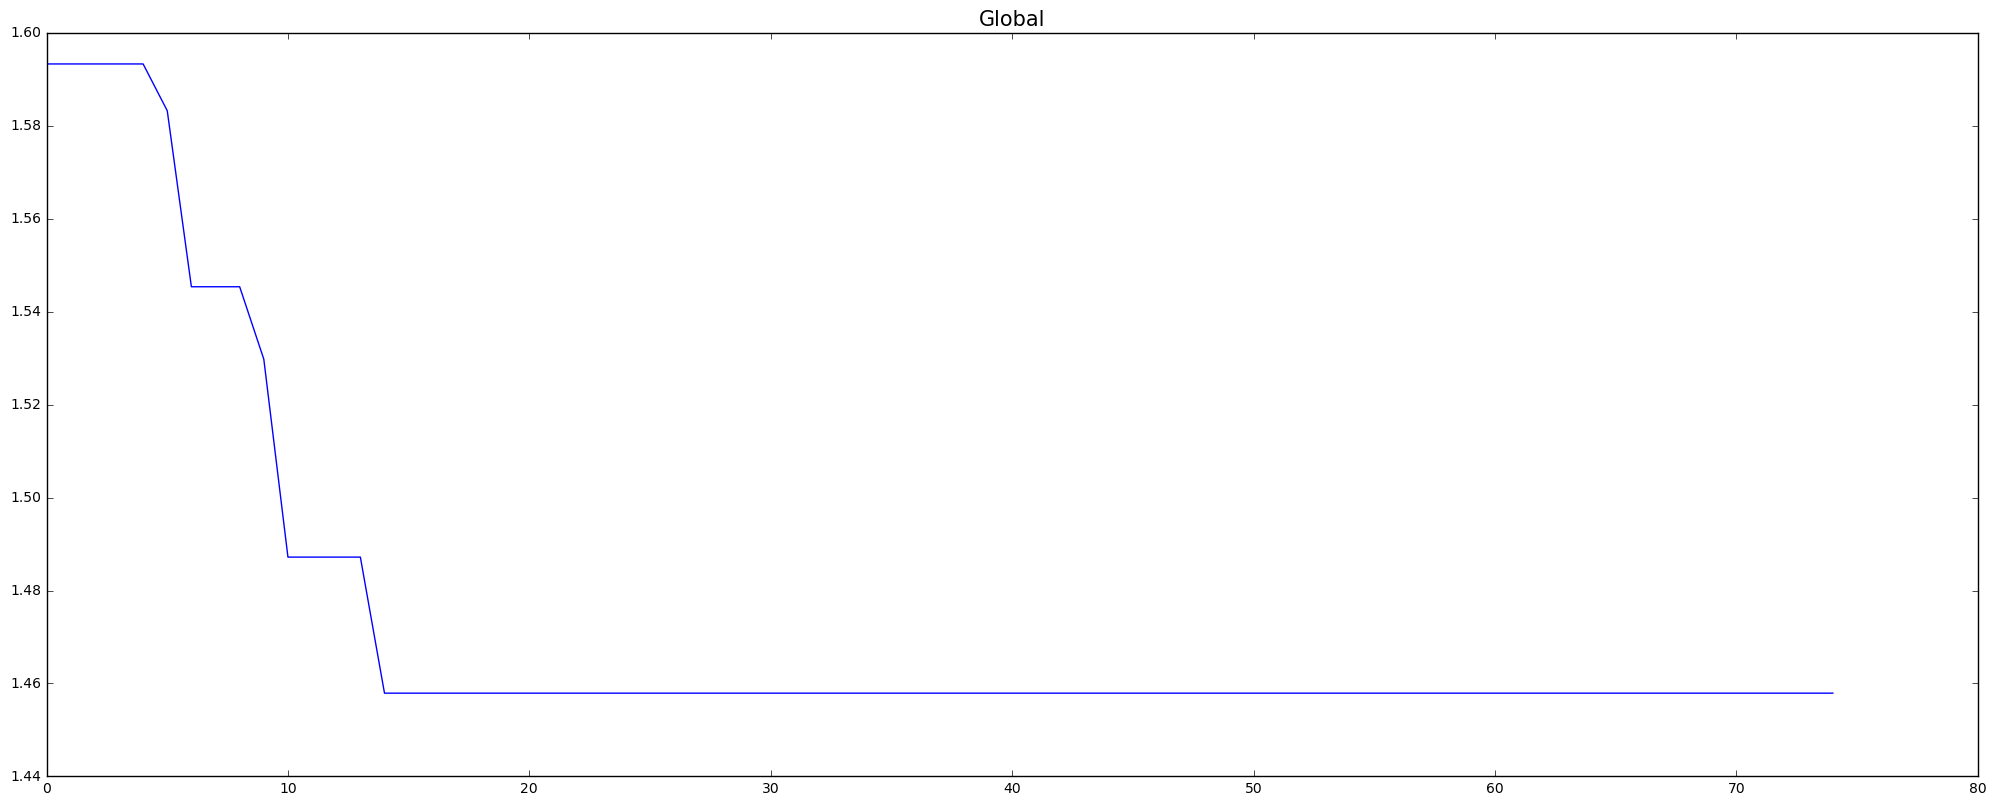

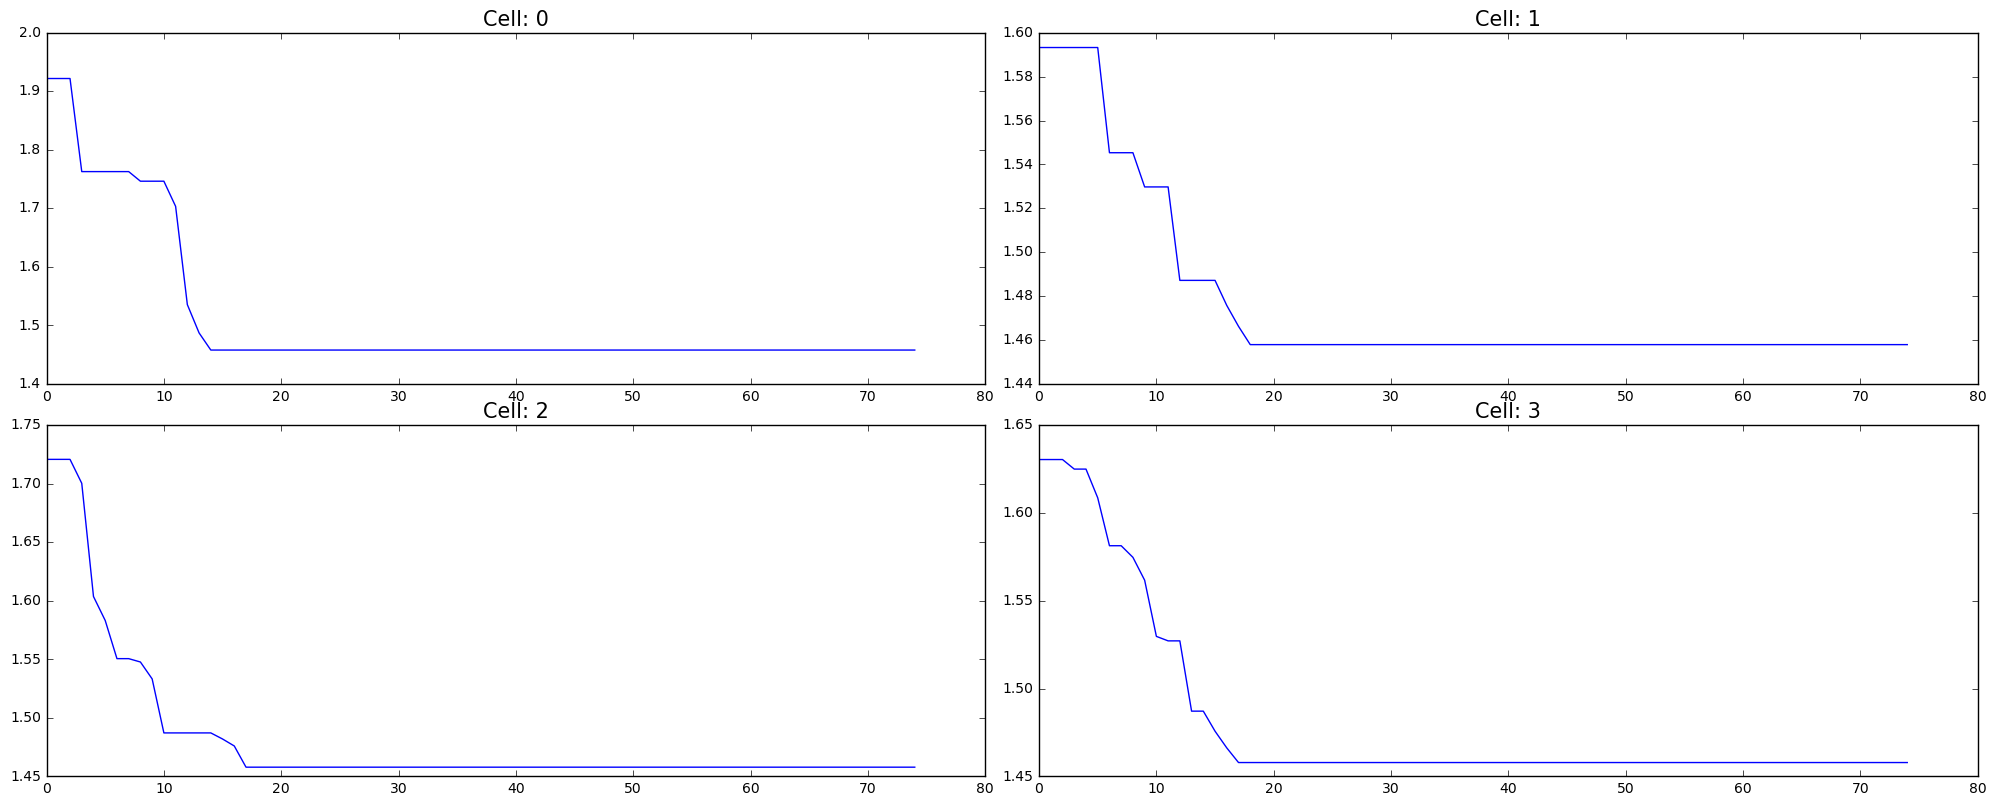

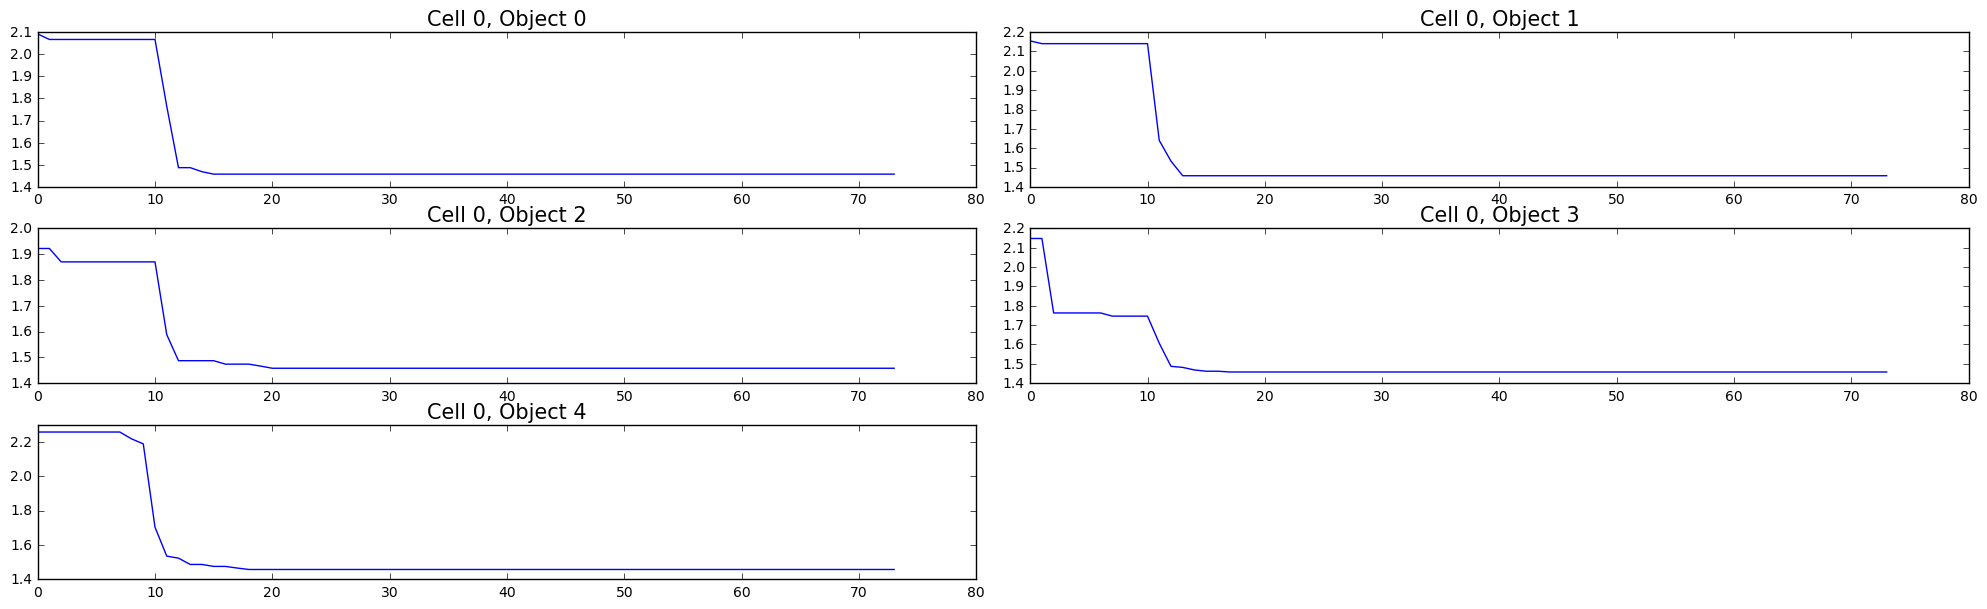

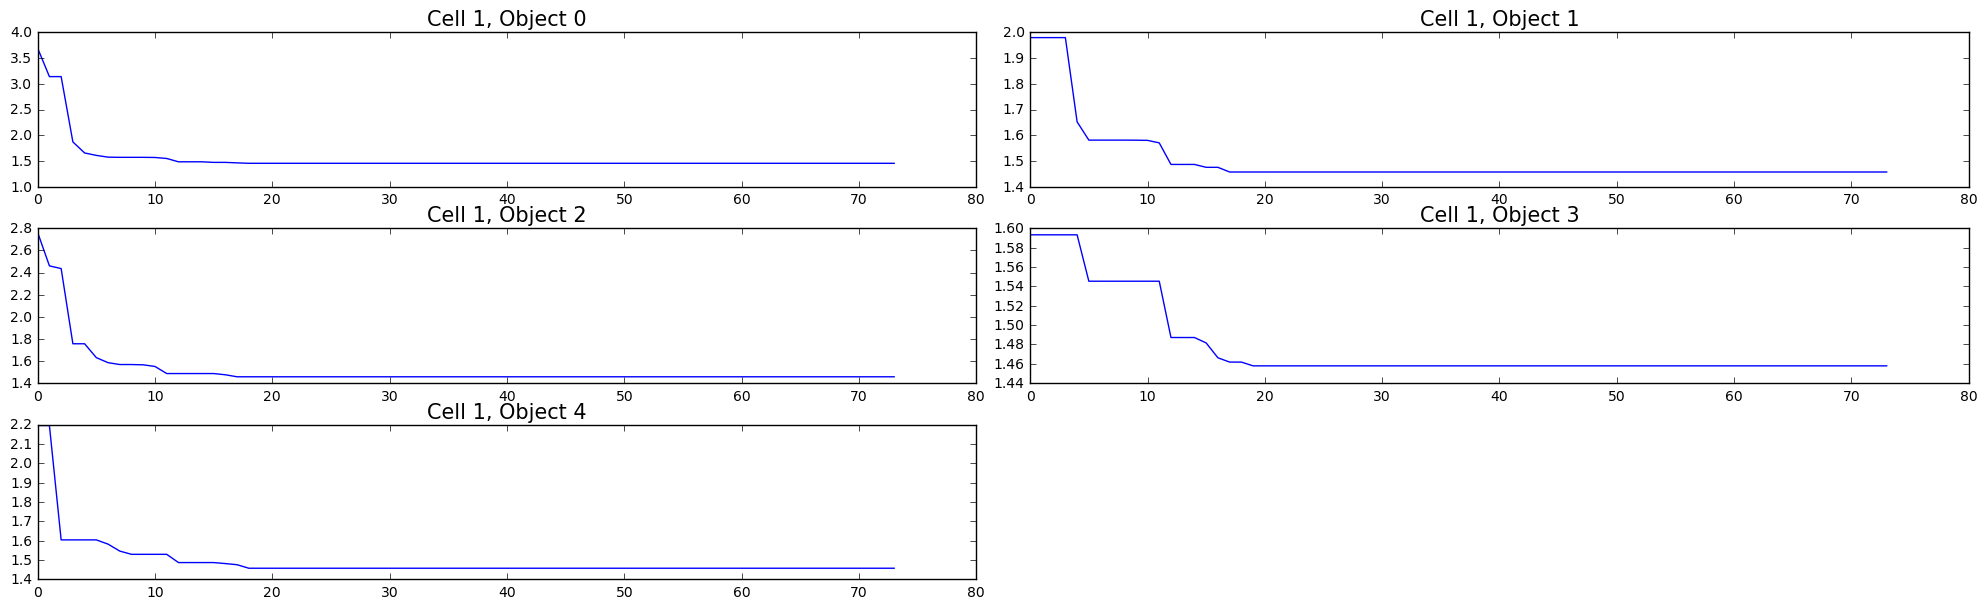

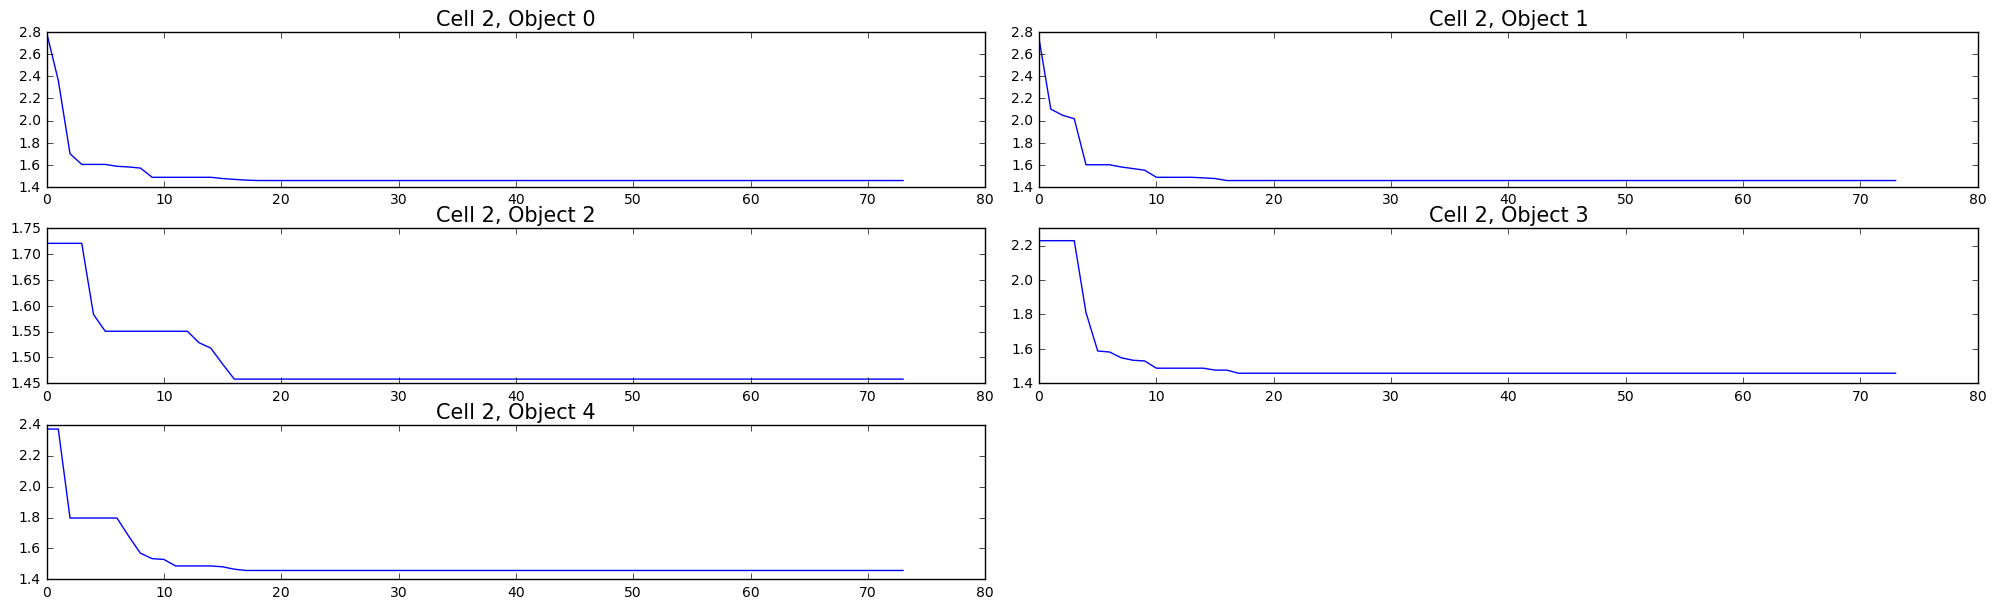

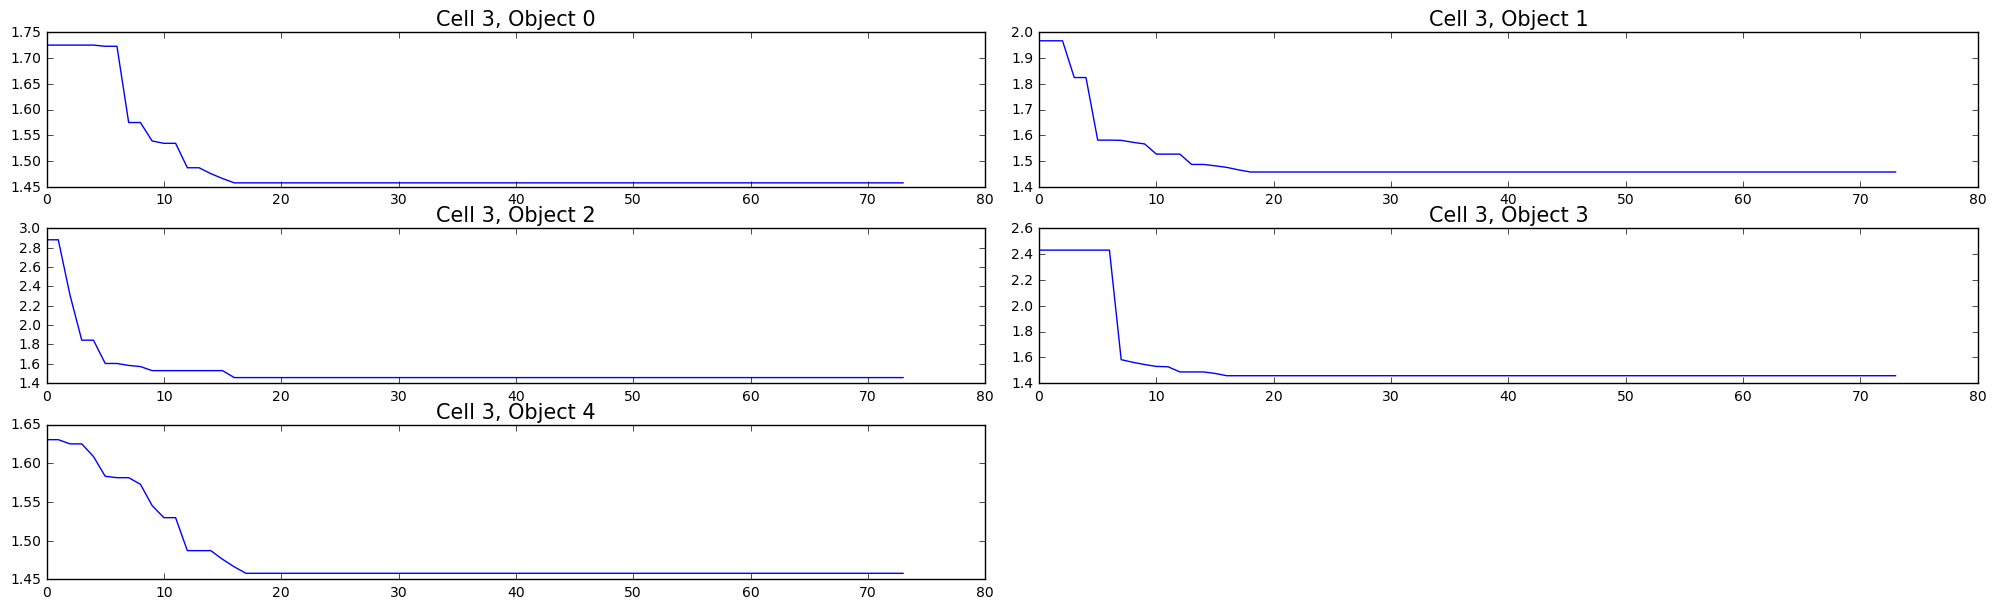

In [82]:
mem_model_wine.plot()

Testing k: 2.000000 [0.206583]
Testing k: 3.000000 [0.180617]
Testing k: 4.000000 [0.192935]
Testing k: 5.000000 [0.177361]
Testing k: 6.000000 [0.165919]
Testing k: 7.000000 [0.169821]
Testing k: 8.000000 [0.178530]
Testing k: 9.000000 [0.181459]
Testing k: 10.000000 [0.186629]
Best configuration is {'k': 2, 'score': 0.20658269409721072}
Testing k: 2.000000 [0.205044]
Testing k: 3.000000 [0.146204]
Testing k: 4.000000 [0.149336]
Testing k: 5.000000 [0.149579]
Testing k: 6.000000 [0.151075]
Testing k: 7.000000 [0.138750]
Testing k: 8.000000 [0.148655]
Testing k: 9.000000 [0.153513]
Testing k: 10.000000 [0.160915]
Best configuration is {'k': 2, 'score': 0.20504366613790836}
Creating object 0
Creating object 0
Creating object 0
Creating object 0
Creating object 1
Creating object 1
Creating object 1
Creating object 1
Creating cell 0
Creating cell 1
Creating cell 2
Creating cell 3
Creating object 2
Creating object 2
Creating object 2
Creating object 2
Creating object 3
Creating object 3
Cr

100%|██████████| 75/75 [00:55<00:00,  1.71it/s]      | 1/75 [00:00<00:17,  4.35it/s]


Adjustes Rand Score for KMeans 0.015525
Adjustes Rand Score for Mem 0.015038
Adjustes Rand Score for Agglomerative Clustering 0.017449


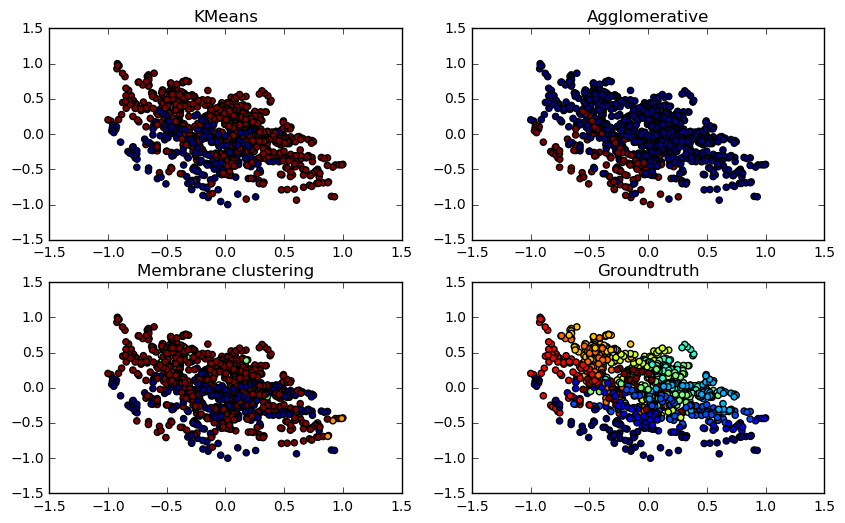

In [88]:
# UCI dataset: Vowel data
data = datasets.fetch_mldata('vowel')
x_vowel, y_vowel = data['data'], data['target']
km_v, ac_v, mem_v, mem_model_v = test_data(x_vowel)
plot_data(x_vowel, km_v, ac_v, mem_v, y_vowel)
show_scores(km_v, ac_v, mem_v, y_vowel)

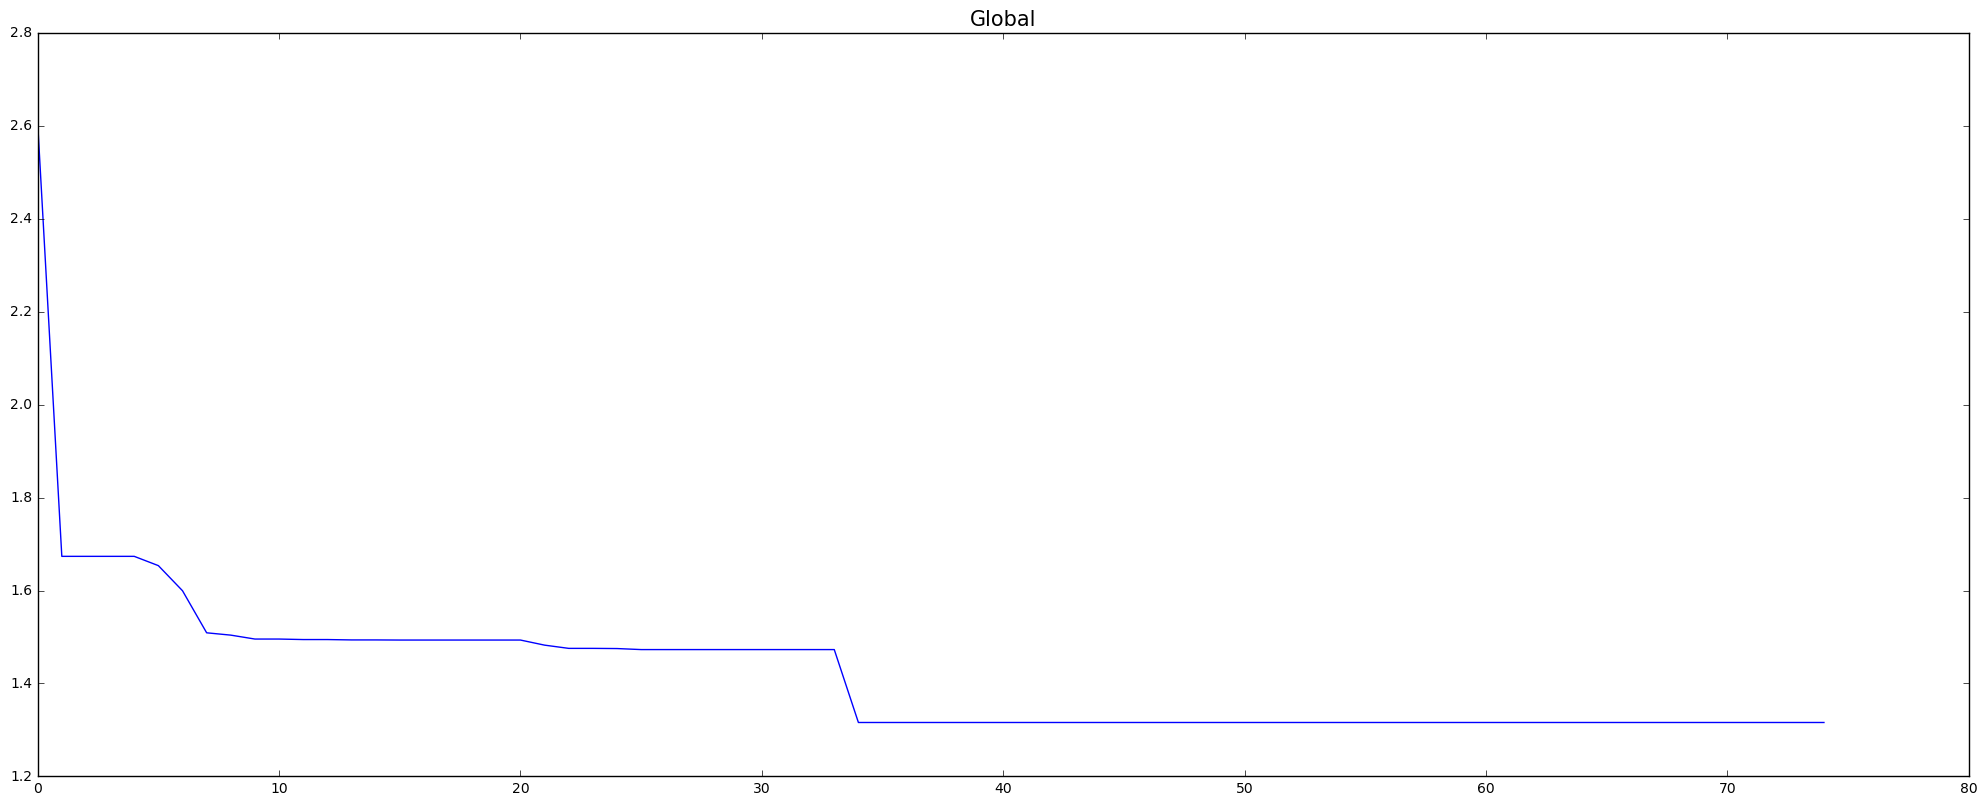

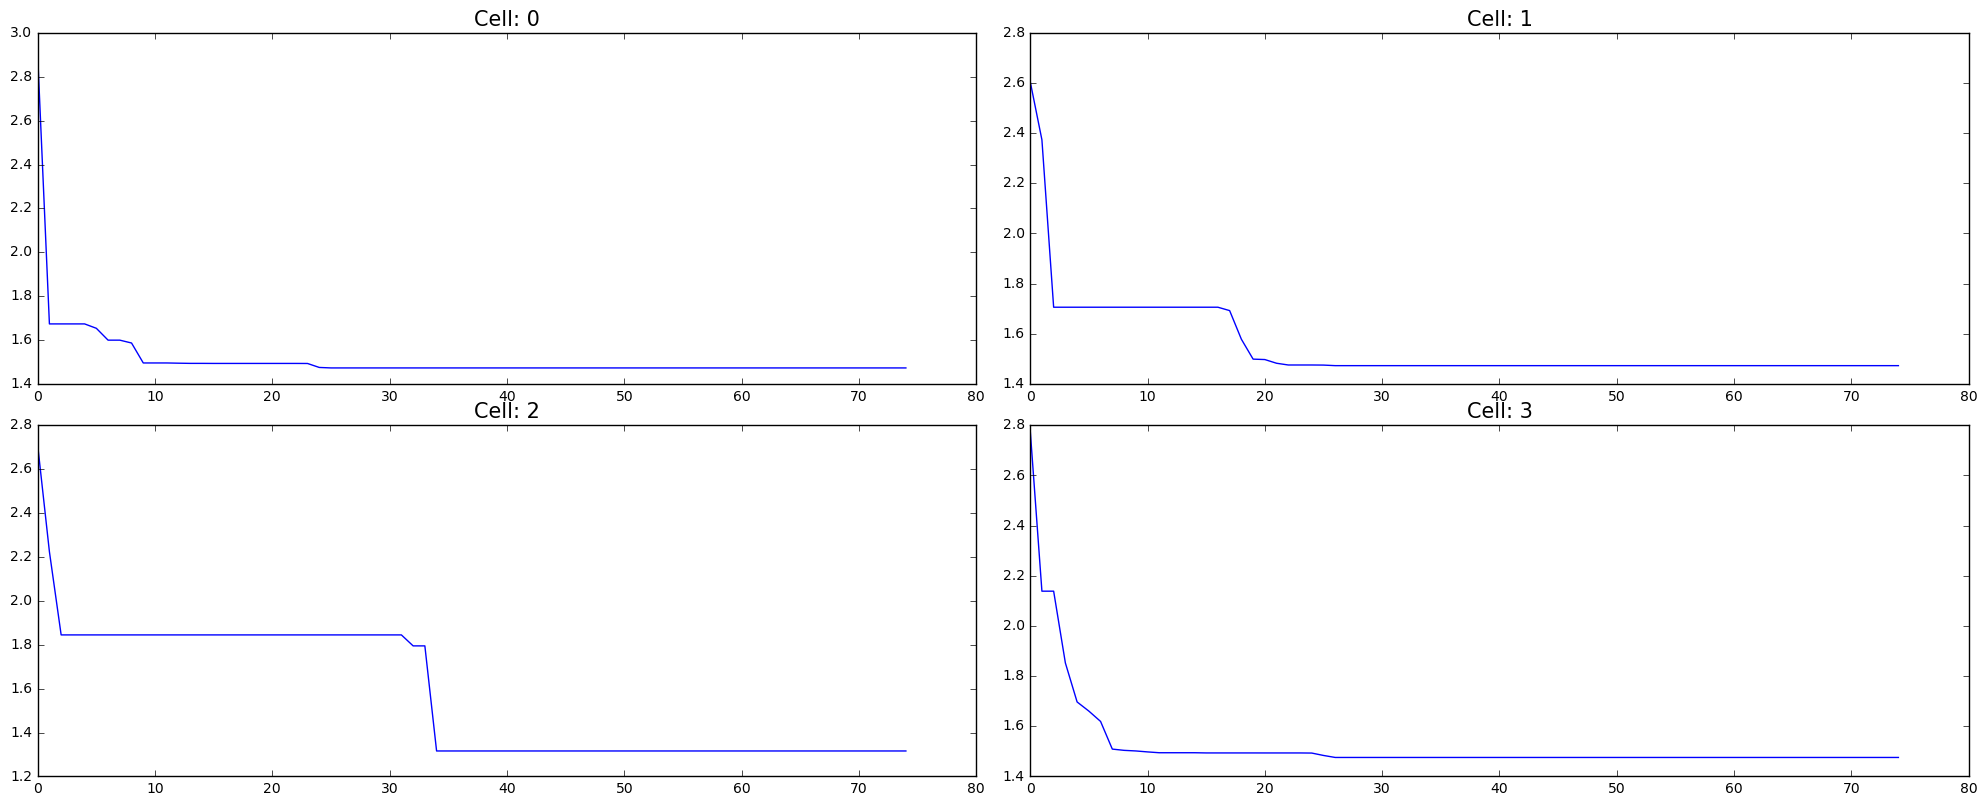

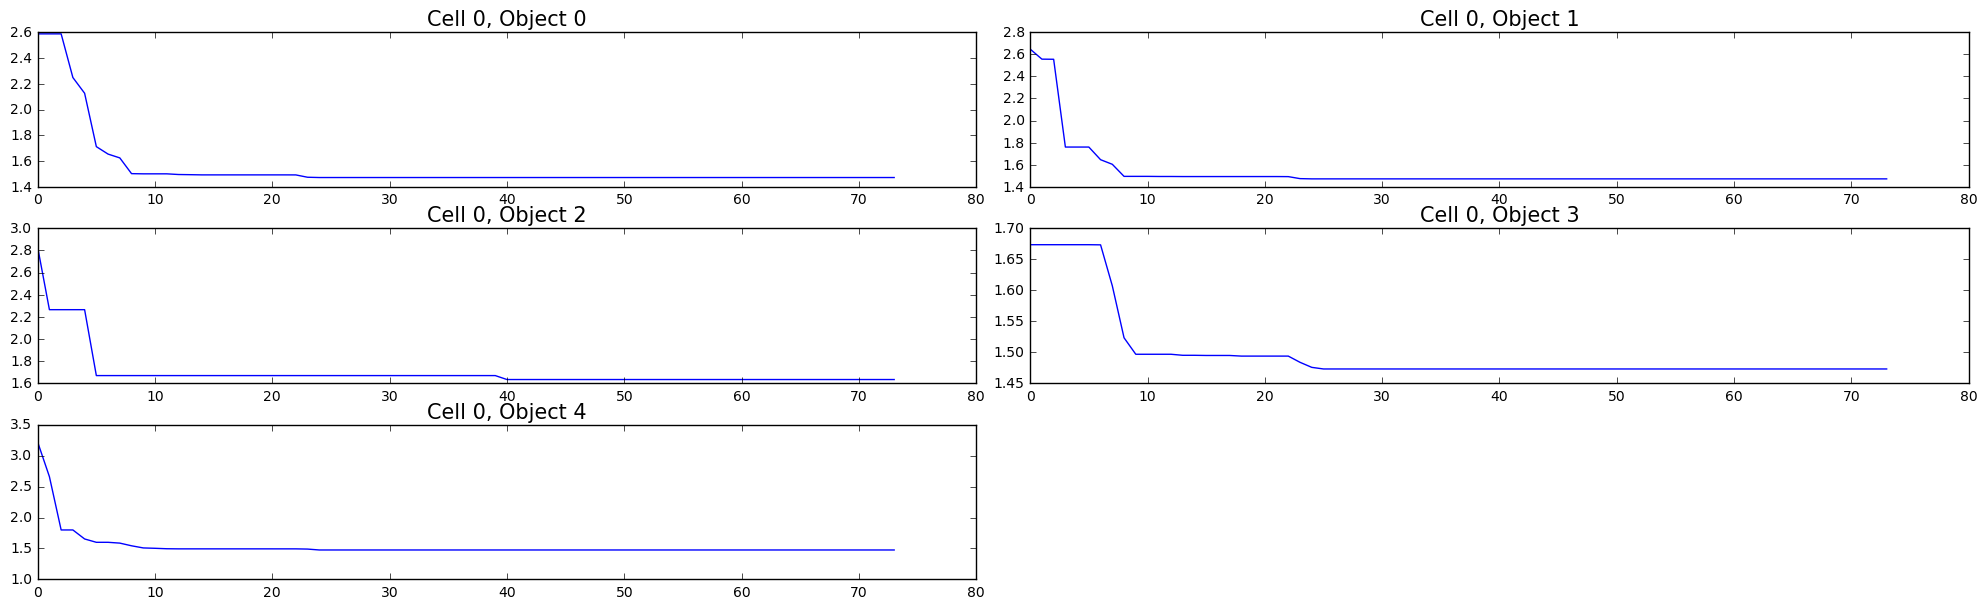

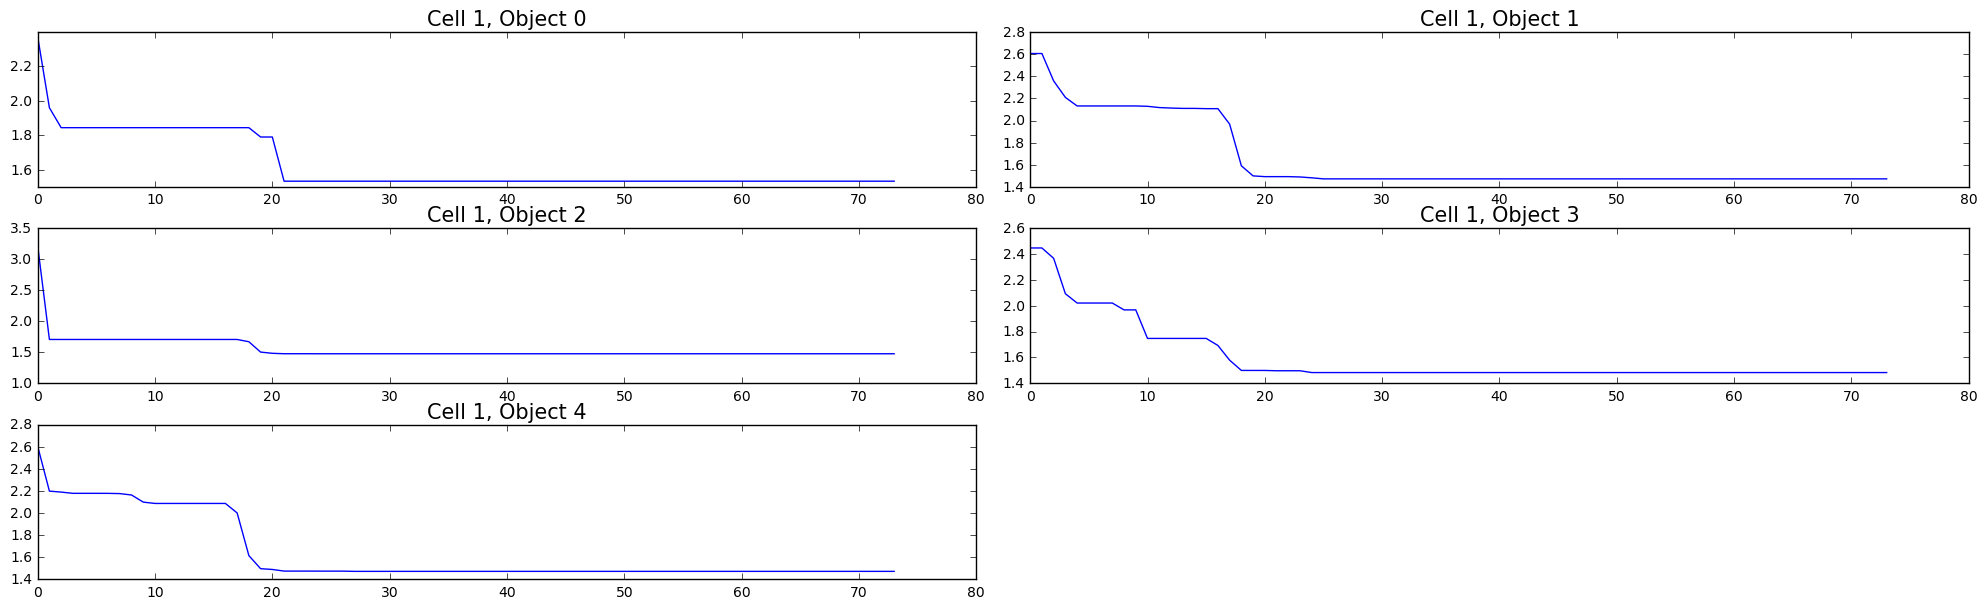

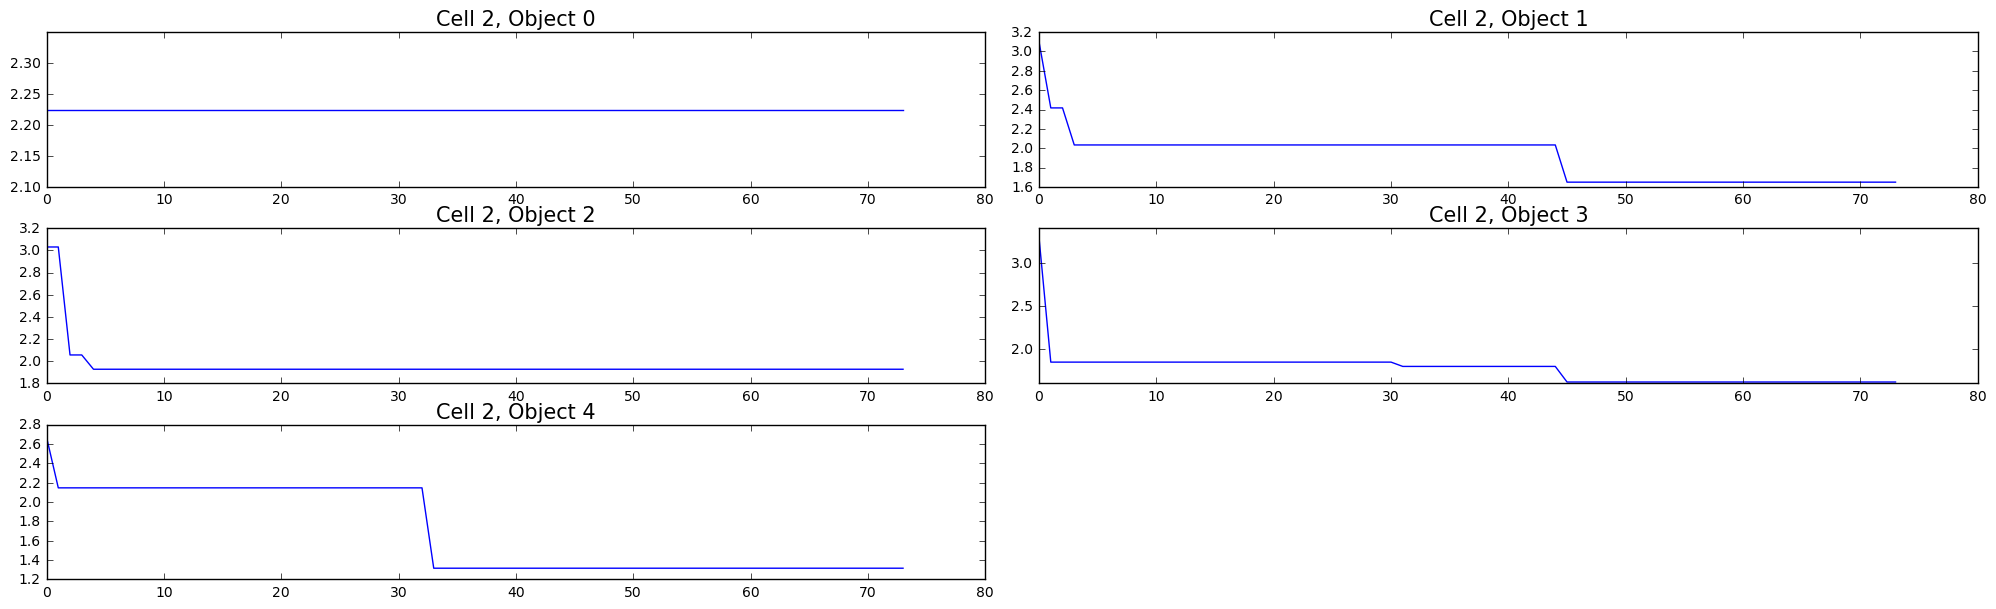

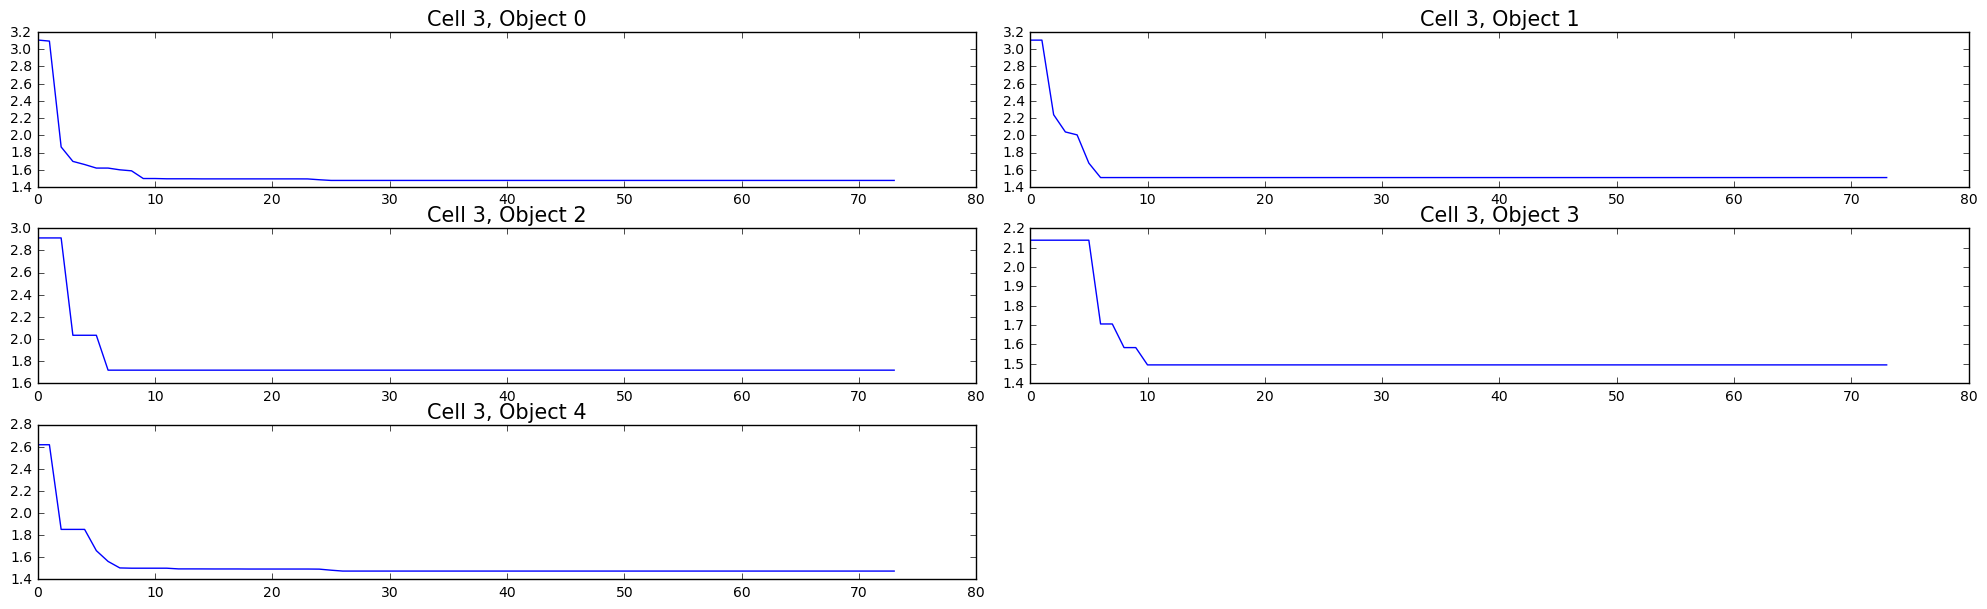

In [89]:
mem_model_v.plot()

Testing k: 2.000000 [0.524073]
Testing k: 3.000000 [0.525244]
Testing k: 4.000000 [0.360163]
Testing k: 5.000000 [0.368212]
Testing k: 6.000000 [0.379665]
Testing k: 7.000000 [0.361395]
Testing k: 8.000000 [0.384548]
Testing k: 9.000000 [0.381298]
Testing k: 10.000000 [0.333290]
Best configuration is {'k': 3, 'score': 0.52524372010493259}
Testing k: 2.000000 [0.521353]
Testing k: 3.000000 [0.526722]
Testing k: 4.000000 [0.304983]
Testing k: 5.000000 [0.315541]
Testing k: 6.000000 [0.323812]
Testing k: 7.000000 [0.327248]
Testing k: 8.000000 [0.337753]
Testing k: 9.000000 [0.341024]
Testing k: 10.000000 [0.339869]
Best configuration is {'k': 3, 'score': 0.52672157578929668}
Creating object 0
Creating object 0
Creating object 0
Creating object 0
Creating object 1
Creating object 1
Creating object 1
Creating object 2
Creating object 1
Creating object 2
Creating cell 0
Creating cell 1
Creating cell 2
Creating cell 3
Creating object 3
Creating object 2
Creating object 3
Creating object 2
Cr

100%|██████████| 75/75 [00:17<00:00,  4.00it/s]      | 1/75 [00:00<00:15,  4.65it/s]


Adjustes Rand Score for KMeans 0.241745
Adjustes Rand Score for Mem 0.192681
Adjustes Rand Score for Agglomerative Clustering 0.219659


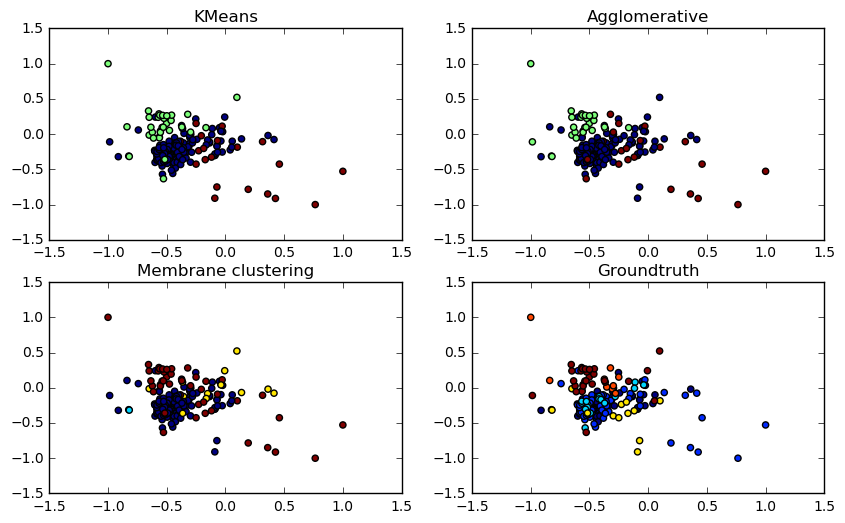

In [98]:
# Breast cancer
data = datasets.fetch_mldata('glass')
x_glass, y_glass = data['data'], data['target']
km_g, ac_g, mem_g, mem_model_glass = test_data(x_glass)
plot_data(x_glass, km_g, ac_g, mem_g, y_glass)
show_scores(km_g, ac_g, mem_g, y_glass)